In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.externals import joblib

from helpfunction import sciNot

%matplotlib inline
gr      = 1.618

In [2]:
min_dedx_hits=2

# Tracks

In [3]:
dataset = pd.read_pickle('../Input/XGBoost/trackFrame_fidvol.pckl')

In [4]:
dataset.head()

,track_dedx,track_dedx_avg,track_dedx_hits,track_pca,predict_em,predict_mu,predict_cos,predict_pi,predict_p,vx,...,vz,track_containment,track_is_daughter,track_length,track_sh_daughter,track_tr_daughter,track_vtx,track_vtx_end,true_e,true_mu
0,0.093979,0.102463,4.0,0.997070,0.007759,0.750977,0.008698,0.231079,0.001492,36.073578,...,811.450012,False,True,66.790088,False,True,0.070991,66.791347,False,False
1,0.373662,0.326146,4.0,0.960449,0.288086,0.144897,0.003736,0.556641,0.006557,36.073578,...,811.450012,False,True,23.822821,False,False,43.937509,65.632448,False,False
2,0.241747,0.218862,3.0,0.999023,0.014725,0.011597,0.961914,0.008034,0.003828,36.073578,...,811.450012,False,True,49.450229,True,False,0.235594,49.675376,False,False
3,2.122207,13.154626,12.0,1.000000,0.000046,0.022476,0.974609,0.001173,0.001669,244.315079,...,274.585510,True,True,255.768274,False,False,0.456691,256.214394,False,False
4,1.911418,10.771297,12.0,0.999512,0.000382,0.065430,0.919922,0.013466,0.000851,244.315079,...,274.585510,False,True,130.350249,False,False,54.972802,96.896016,False,False


In [5]:
# For now, quick fix: require at least two hits in track_dedx_hits, otherwise track_dedx is nonsence.
dataset_cleaned = dataset[dataset['track_dedx_hits']>=min_dedx_hits]
dataset_cleaned.drop(['vx','vy','vz'],inplace=True,axis=1)
dataset_cleaned.head()

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,track_dedx,track_dedx_avg,track_dedx_hits,track_pca,predict_em,predict_mu,predict_cos,predict_pi,predict_p,track_containment,track_is_daughter,track_length,track_sh_daughter,track_tr_daughter,track_vtx,track_vtx_end,true_e,true_mu
0,0.093979,0.102463,4.0,0.997070,0.007759,0.750977,0.008698,0.231079,0.001492,False,True,66.790088,False,True,0.070991,66.791347,False,False
1,0.373662,0.326146,4.0,0.960449,0.288086,0.144897,0.003736,0.556641,0.006557,False,True,23.822821,False,False,43.937509,65.632448,False,False
2,0.241747,0.218862,3.0,0.999023,0.014725,0.011597,0.961914,0.008034,0.003828,False,True,49.450229,True,False,0.235594,49.675376,False,False
3,2.122207,13.154626,12.0,1.000000,0.000046,0.022476,0.974609,0.001173,0.001669,True,True,255.768274,False,False,0.456691,256.214394,False,False
4,1.911418,10.771297,12.0,0.999512,0.000382,0.065430,0.919922,0.013466,0.000851,False,True,130.350249,False,False,54.972802,96.896016,False,False


In [6]:
seed = 7
test_size = 0.33

X=dataset_cleaned.drop(columns=['true_e','true_mu'])
X=X.as_matrix()
Y_mu=dataset_cleaned['true_mu']
Y_e=dataset_cleaned['true_e']
#X=dataset_cleaned[['track_dedx','track_pca']]



In [7]:
# fit model no training data
X_train, X_test, y_train, y_test_mu = train_test_split(X, Y_mu, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred_mu = model.predict_proba(X_test)
print(classification_report(y_test_mu, model.predict(X_test)))
joblib.dump(model, 'model_tr_mu.pkl') 

             precision    recall  f1-score   support

      False       0.95      0.96      0.95     29576
       True       0.89      0.87      0.88     11736

avg / total       0.93      0.93      0.93     41312



/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['model_tr_mu.pkl']

In [8]:
# fit model no training data
X_train, X_test, y_train, y_test_e = train_test_split(X, Y_e, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred_e = model.predict_proba(X_test)
print(classification_report(y_test_e,model.predict(X_test)))
joblib.dump(model, 'model_tr_e.pkl') 

             precision    recall  f1-score   support

      False       0.96      0.99      0.98     39038
       True       0.74      0.29      0.41      2274

avg / total       0.95      0.96      0.95     41312



/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['model_tr_e.pkl']

In [9]:
y_pred_e[y_test_e==1][:,0]

array([0.63555944, 0.60036504, 0.7371104 , ..., 0.8379467 , 0.42306954,
       0.8750987 ], dtype=float32)

Cut value: 0.24 removes 94.1 % of muon tagged tracks and 9.1 % of not-muon tagged tracks.
Cut value: 0.36 keeps 50.4 % of electron tagged tracks and 2.1 % of not-electron tagged tracks.


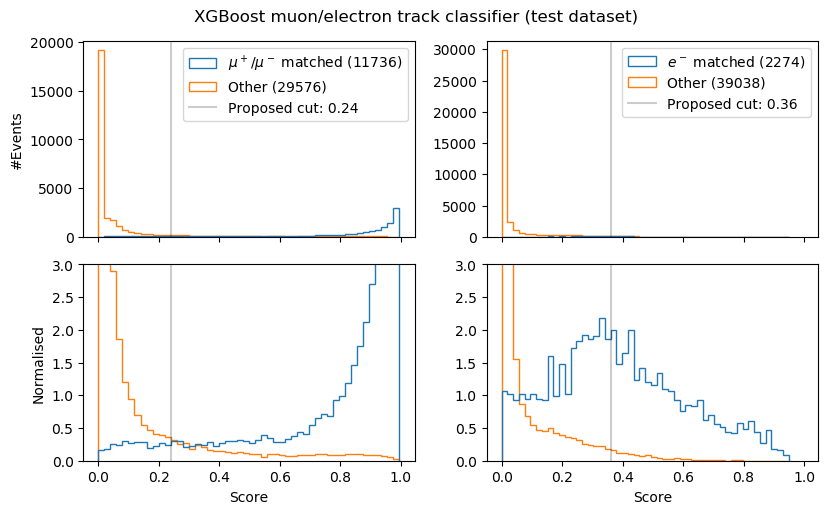

In [10]:
# XGB classification

plt.style.use('default')
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(5.2*gr,5.2),sharex=True)
plt.suptitle(r'XGBoost muon/electron track classifier (test dataset)')
N=50
muon_cut = 0.24
electron_cut=0.36

# Electron track classification
arr_e  = y_pred_e[y_test_e==1][:,1]
arr_ne = y_pred_e[y_test_e==0][:,1]

# Muon track classification
arr_mu  = y_pred_mu[y_test_mu==1][:,1]
arr_nmu = y_pred_mu[y_test_mu==0][:,1]

label_mu=(r'$\mu^+/\mu^-$ matched ('+str(len(arr_mu))+')','Other ('+str(len(arr_nmu))+')')
label_e=(r'$e^-$ matched ('+str(len(arr_e))+')','Other ('+str(len(arr_ne))+')')

ax[0][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,normed=False)
ax[1][0].set_xlabel('Score')
ax[0][0].set_ylabel('#Events')
ax[0][0].legend()

ax[1][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,normed=True)
ax[1][0].set_ylim(0,3)
ax[1][0].set_ylabel('Normalised')


ax[0][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=False)
ax[1][1].set_xlabel('Score')
#ax[0][1].set_ylabel('#Events')
ax[0][1].legend()

ax[1][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[1][1].set_ylim(0,3)
#ax[1][1].set_ylabel('Normalised')


ax[0][0].axvline(x=muon_cut,alpha=.2,color='k',label='Proposed cut: '+str(muon_cut))
ax[1][0].axvline(x=muon_cut,alpha=.2,color='k',label='Proposed cut: '+str(muon_cut))

ax[0][1].axvline(x=electron_cut,alpha=.2,color='k',label='Proposed cut: '+str(electron_cut))
ax[1][1].axvline(x=electron_cut,alpha=.2,color='k',label='Proposed cut: '+str(electron_cut))



#offset=0.05
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc='upper right')
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc='upper right')


plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('XGB_track.pdf')

print('Cut value:',muon_cut,'removes', sciNot(sum(arr_mu>muon_cut) / len(arr_mu)*100),'% of muon tagged tracks and',
      sciNot(sum(arr_nmu>muon_cut) / len(arr_nmu)*100),'% of not-muon tagged tracks.')

print('Cut value:',electron_cut,'keeps', sciNot(sum(arr_e>electron_cut) / len(arr_e)*100),'% of electron tagged tracks and',
      sciNot(sum(arr_ne>electron_cut) / len(arr_ne)*100),'% of not-electron tagged tracks.')


In [11]:
print(len(dataset_cleaned.index))
print(dataset_cleaned['true_e'].value_counts())
print(dataset_cleaned['true_mu'].value_counts())
print(dataset_cleaned['track_containment'].value_counts())
print(dataset_cleaned['track_sh_daughter'].value_counts())
print(dataset_cleaned['track_is_daughter'].value_counts())

125186
False    118216
True       6970
Name: true_e, dtype: int64
False    89793
True     35393
Name: true_mu, dtype: int64
True     97031
False    28155
Name: track_containment, dtype: int64
False    111333
True      13853
Name: track_sh_daughter, dtype: int64
False    108445
True      16741
Name: track_is_daughter, dtype: int64


In [12]:
# Question: how many tracks have a muon score of lower than muon cut, 
# have an electron score higher than electron_cut and are not an electron.
print(sum( (y_pred_mu[:,1]<muon_cut)*(y_pred_e[:,1]>electron_cut)*(y_test_e==0)))
print(sum( (y_pred_mu[:,1]<muon_cut)*(y_test_e==0)))


713
25607


/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


# Showers

In [13]:
dataset = pd.read_pickle('../Input/XGBoost/showerFrame_fidvol.pckl')

In [14]:
dataset.head()

,shower_dedx,shower_dedx_avg,shower_dedx_hits,shower_pca,shower_open_angle,shower_length,shower_containment_q,shower_sp_profile,shower_is_daughter,shower_sh_daughter,shower_tr_daughter,shower_vtx,true_e,true_mu
0,3.135025,16.841373,16.0,0.916504,0.221802,22.125000,0.393415,0.648575,True,False,False,14.957309,False,False
1,3.051837,8.656431,7.0,0.968262,0.094971,20.015625,0.393415,0.648575,True,False,False,307.884709,False,False
2,0.006560,0.006460,4.0,0.629395,0.065430,9.226562,0.393415,0.648575,True,False,False,1.011630,False,False
3,0.097360,0.417215,9.0,0.939941,0.219360,37.593750,0.320908,0.134881,True,False,False,43.939436,False,False
4,1.697985,4.193395,4.0,0.927246,0.464355,4.945312,0.320908,0.134881,True,False,False,3.789347,False,False


In [15]:
# For now, quick fix: require at least two hits in track_dedx_hits, otherwise track_dedx is nonsence.
dataset_cleaned = dataset[dataset['shower_dedx_hits']>=min_dedx_hits]

dataset_cleaned.head()

,shower_dedx,shower_dedx_avg,shower_dedx_hits,shower_pca,shower_open_angle,shower_length,shower_containment_q,shower_sp_profile,shower_is_daughter,shower_sh_daughter,shower_tr_daughter,shower_vtx,true_e,true_mu
0,3.135025,16.841373,16.0,0.916504,0.221802,22.125000,0.393415,0.648575,True,False,False,14.957309,False,False
1,3.051837,8.656431,7.0,0.968262,0.094971,20.015625,0.393415,0.648575,True,False,False,307.884709,False,False
2,0.006560,0.006460,4.0,0.629395,0.065430,9.226562,0.393415,0.648575,True,False,False,1.011630,False,False
3,0.097360,0.417215,9.0,0.939941,0.219360,37.593750,0.320908,0.134881,True,False,False,43.939436,False,False
4,1.697985,4.193395,4.0,0.927246,0.464355,4.945312,0.320908,0.134881,True,False,False,3.789347,False,False


In [16]:
seed = 7
test_size = 0.33

X=dataset_cleaned.drop(columns=['true_e','true_mu'])
X=X.as_matrix()
Y_mu=dataset_cleaned['true_mu']
Y_e=dataset_cleaned['true_e']
#X=dataset_cleaned[['track_dedx','track_pca']]

In [17]:
# fit model no training data
X_train, X_test, y_train, y_test_e = train_test_split(X, Y_e, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred_e = model.predict_proba(X_test)
print(classification_report(y_test_e,model.predict(X_test)))
joblib.dump(model, 'model_sh_e.pkl') 

             precision    recall  f1-score   support

      False       0.84      0.91      0.88     26791
       True       0.81      0.68      0.74     14152

avg / total       0.83      0.83      0.83     40943



/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['model_sh_e.pkl']

In [18]:
# fit model no training data
X_train, X_test, y_train, y_test_mu = train_test_split(X, Y_mu, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred_mu = model.predict_proba(X_test)
print(classification_report(y_test_mu, model.predict(X_test)))
joblib.dump(model, 'model_sh_mu.pkl') 

             precision    recall  f1-score   support

      False       0.95      0.99      0.97     38473
       True       0.68      0.19      0.29      2470

avg / total       0.93      0.95      0.93     40943



/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['model_sh_mu.pkl']

Cut value: 0.28 removes 33.6 % of muon tagged showers and 2.0 % of not-muon tagged showers.
Cut value: 0.85 keeps 35.8 % of electron tagged showers and 0.9 % of not-electron tagged showers.


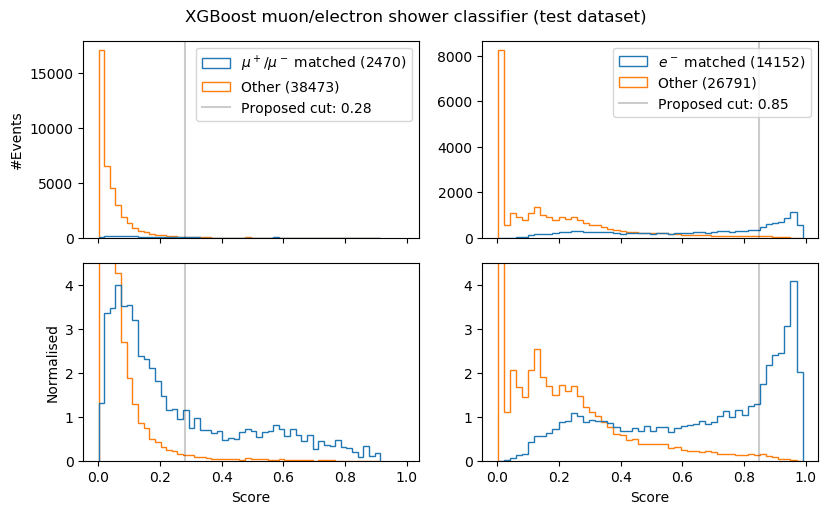

In [19]:
# XGB classification

plt.style.use('default')
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(5.2*gr,5.2),sharex=True)
plt.suptitle(r'XGBoost muon/electron shower classifier (test dataset)')
N=50
muon_cut = 0.28
electron_cut=0.85

# Electron track classification
arr_e  = y_pred_e[y_test_e==1][:,1]
arr_ne = y_pred_e[y_test_e==0][:,1]

# Muon track classification
arr_mu  = y_pred_mu[y_test_mu==1][:,1]
arr_nmu = y_pred_mu[y_test_mu==0][:,1]

label_mu=(r'$\mu^+/\mu^-$ matched ('+str(len(arr_mu))+')','Other ('+str(len(arr_nmu))+')')
label_e=(r'$e^-$ matched ('+str(len(arr_e))+')','Other ('+str(len(arr_ne))+')')

ax[0][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,normed=False)
ax[1][0].set_xlabel('Score')
ax[0][0].set_ylabel('#Events')
ax[0][0].legend()

ax[1][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,normed=True)
ax[1][0].set_ylim(0,4.5)
ax[1][0].set_ylabel('Normalised')


ax[0][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=False)
ax[1][1].set_xlabel('Score')
#ax[0][1].set_ylabel('#Events')
ax[0][1].legend()

ax[1][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[1][1].set_ylim(0,4.5)
#ax[1][1].set_ylabel('Normalised')


ax[0][0].axvline(x=muon_cut,alpha=.2,color='k',label='Proposed cut: '+str(muon_cut))
ax[1][0].axvline(x=muon_cut,alpha=.2,color='k',label='Proposed cut: '+str(muon_cut))

ax[0][1].axvline(x=electron_cut,alpha=.2,color='k',label='Proposed cut: '+str(electron_cut))
ax[1][1].axvline(x=electron_cut,alpha=.2,color='k',label='Proposed cut: '+str(electron_cut))



#offset=0.05
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc='upper right')
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc='upper centre')


plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('XGB_shower.pdf')

print('Cut value:',muon_cut,'removes', sciNot(sum(arr_mu>muon_cut) / len(arr_mu)*100),'% of muon tagged showers and',
      sciNot(sum(arr_nmu>muon_cut) / len(arr_nmu)*100),'% of not-muon tagged showers.')

print('Cut value:',electron_cut,'keeps', sciNot(sum(arr_e>electron_cut) / len(arr_e)*100),'% of electron tagged showers and',
      sciNot(sum(arr_ne>electron_cut) / len(arr_ne)*100),'% of not-electron tagged showers.')
